In [14]:
from finlab import login
login('97Y21Yf07Tokqp6rnUxsQKHbc4j+HosTsqE5DNh2oWLA9n+pxaCibJSKUK190ocZ#vip_m')

輸入成功!


In [15]:
import pandas as pd
import numpy as np
from finlab import data
import matplotlib.pyplot as plt

# ======================================
# 0. 參數設定
# ======================================
N_DAYS = 5                # 計算近 N 日漲幅
MIN_LIQ_PCT = 0.6         # 流動性前 60%
TOP_GROUPS = 5           # 每天挑出最強 5 個族群
TOP_STOCKS = 15            # 每個交易日最多選 5 檔股票

# 權重設定
weights = {
    "ret": 1.5,      # 漲幅權重
    "turnover": 1.0, # 成交額權重
    "inst": 1.0,     # 法人權重
    "conc": 1.0      # 集中度權重
}

# ======================================
# 1. 基礎資料
# ======================================
close = data.get("price:收盤價")
volume = data.get("price:成交股數")

# [新增] 抓取大盤資料 (加權指數)
benchmark = data.get('taiex_total_index:收盤指數')

# 確保抓取到資料再計算
if benchmark is not None and not benchmark.empty:
    benchmark_ma200 = benchmark.rolling(200).mean()
else:
    print("Warning: 無法取得大盤資料，將忽略大盤濾網")
    benchmark = pd.Series(dtype=float)
    benchmark_ma200 = pd.Series(dtype=float)

# [新增] 獲取有個股期貨的股票清單
with data.universe(market='STOCK_FUTURE'):
    stock_futures_id = data.get('price:收盤價').columns

# 族群資料
theme_raw = data.get("security_industry_themes")

# 法人與主力
foreign = data.get('institutional_investors_trading_summary:外資自營商買賣超股數')
trust = data.get('institutional_investors_trading_summary:投信買賣超股數')
dealer = data.get('institutional_investors_trading_summary:自營商買賣超股數(自行買賣)')

# 營收資料
rev_yoy = data.get("monthly_revenue:去年同月增減(%)")

# 建立「股票 → 族群」對應表
if 'key_date' in theme_raw.columns:
    theme = theme_raw.sort_values("key_date").groupby("stock_id").last()
else:
    theme = theme_raw.drop_duplicates("stock_id", keep="last").set_index("stock_id")

def parse_category(cat_str):
    try:
        return cat_str.replace("[", "").replace("]", "").split(",")[0].strip("' \"")
    except:
        return "Unknown"

if 'category' in theme.columns:
    theme["main_category"] = theme["category"].apply(parse_category)
    group_mapper = theme["main_category"]
else:
    group_mapper = pd.Series()

# 計算交集
common_cols = (
    close.columns
    .intersection(volume.columns)
    .intersection(foreign.columns)
    .intersection(trust.columns)
    .intersection(dealer.columns)
    .intersection(rev_yoy.columns)
    .intersection(group_mapper.index)
    .intersection(stock_futures_id)    # [新增] 必備個股期貨
)

# 只保留有資料且有個股期貨的股票
close = close[common_cols]
volume = volume[common_cols]
foreign = foreign[common_cols]
trust = trust[common_cols]
dealer = dealer[common_cols]
rev_yoy = rev_yoy[common_cols].reindex(close.index, method='ffill')
group_mapper = group_mapper[common_cols]

# ======================================
# 2. 計算每日因子
# ======================================

# -- 2.1 近 N 日漲幅
ret = close.pct_change(N_DAYS)

# -- 2.2 流動性：成交金額
turnover = close * volume

# -- 2.3 前一日法人買超
inst_total = foreign + trust + dealer
inst_buy_yday = inst_total.shift(1)

# -- 2.4 主力集中度
inst_concentration = inst_total / volume.replace(0, np.nan)

# ======================================
# 3. 計算「族群強度」
# ======================================
group_ret = ret.groupby(group_mapper, axis=1).mean()
group_turnover = turnover.groupby(group_mapper, axis=1).sum()
group_inst = inst_buy_yday.groupby(group_mapper, axis=1).sum()
group_conc = inst_concentration.groupby(group_mapper, axis=1).mean()

# 計算加權分數
group_score = (
      group_ret.rank(axis=1, pct=True) * weights["ret"]
    + group_turnover.rank(axis=1, pct=True) * weights["turnover"]
    + group_inst.rank(axis=1, pct=True) * weights["inst"]
    + group_conc.rank(axis=1, pct=True) * weights["conc"]
)

# 每天挑出最強 TOP_GROUPS 個族群
top_groups_daily = group_score.rank(axis=1, ascending=False) <= TOP_GROUPS

# ======================================
# 4. 在強勢族群中挑個股
# ======================================
selected_stocks = {}

for date in close.index:
    if date not in top_groups_daily.index:
        continue

    strong_groups_mask = top_groups_daily.loc[date]
    strong_groups = strong_groups_mask[strong_groups_mask].index.tolist()
    if len(strong_groups) == 0:
        continue

    stocks_in_groups = group_mapper[group_mapper.isin(strong_groups)].index.tolist()
    if len(stocks_in_groups) == 0:
        continue
    
    if date not in inst_buy_yday.index or date not in inst_concentration.index:
        continue

    df = pd.DataFrame({
        "ret": ret.loc[date, stocks_in_groups],
        "turnover": turnover.loc[date, stocks_in_groups],
        "inst": inst_buy_yday.loc[date, stocks_in_groups],
        "conc": inst_concentration.loc[date, stocks_in_groups],
        "yoy": rev_yoy.loc[date, stocks_in_groups]
    }).dropna()

    if df.empty:
        continue

    # 條件過濾
    liq_cut = df["turnover"].quantile(1 - MIN_LIQ_PCT)
    df = df[df["turnover"] >= liq_cut]
    df = df[df["inst"] > 0]
    df = df[df["conc"] > 0]
    df = df[df["yoy"] > 0]

    if df.empty:
        continue

    # 個股綜合分數
    df["score"] = (
        df["ret"].rank(pct=True) * weights["ret"]
        + df["turnover"].rank(pct=True) * weights["turnover"]
        + df["inst"].rank(pct=True) * weights["inst"]
        + df["conc"].rank(pct=True) * weights["conc"]
    )

    df = df.sort_values("score", ascending=False).head(TOP_STOCKS)
    selected_stocks[date] = df.index.tolist()

# ======================================
# 5. 結果呈現
# ======================================
df_selected = pd.DataFrame.from_dict(selected_stocks, orient='index').sort_index()

def get_display_info(stock_id):
    if pd.isna(stock_id):
        return ""
    stock_id = str(stock_id)
    if stock_id in theme.index:
        row = theme.loc[stock_id]
        name = row['name'] if 'name' in row else ''
        category = row['main_category'] if 'main_category' in row else ''
        return f"{stock_id} {name} ({category})"
    else:
        return stock_id

df_display = df_selected.applymap(get_display_info)

print("Saving selected stocks to 'selected_futures_stocks_all_YOY.csv'...")
df_display.to_csv('selected_futures_stocks_all_YOY.csv', encoding='utf-8-sig')
df_display.tail(20)

Daily usage: 148.7 / 5000 MB - price:收盤價
Daily usage: 188.2 / 5000 MB - price:成交股數


c:\Users\teraw_rp58jwl\anaconda3\Lib\site-packages\finlab\data\universe.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .pipe(lambda df: pd.Series(True, set(df.stock_id)).reindex(categories.index).fillna(False))
C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_176868\99853973.py:98: FutureWarning: The default fill_method='pad' in FinlabDataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = close.pct_change(N_DAYS)
C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_176868\99853973.py:113: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  group_ret = ret.

Saving selected stocks to 'selected_futures_stocks_all_YOY.csv'...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2025-12-02,2454 聯發科 (半導體),2308 台達電 (LED照明產業),3037 欣興 (印刷電路板),3711 日月光投控 (半導體),2379 瑞昱 (半導體),2330 台積電 (半導體),5347 世界 (半導體),5274 信驊 (半導體),2344 華邦電 (半導體),6223 旺矽 (LED照明產業),2368 金像電 (印刷電路板),8150 南茂 (半導體),8112 至上 (半導體),3406 玉晶光 (LED照明產業),
2025-12-03,3037 欣興 (印刷電路板),3711 日月光投控 (半導體),2454 聯發科 (半導體),2344 華邦電 (半導體),2379 瑞昱 (半導體),2449 京元電子 (半導體),3189 景碩 (半導體),2330 台積電 (半導體),3529 力旺 (半導體),2313 華通 (印刷電路板),5274 信驊 (半導體),8150 南茂 (半導體),2353 宏碁 (電腦及週邊設備),2027 大成鋼 (鋼鐵),6188 廣明 (電腦及週邊設備)
2025-12-04,3037 欣興 (印刷電路板),2382 廣達 (運動科技),8039 台虹 (印刷電路板),6188 廣明 (電腦及週邊設備),6274 台燿 (印刷電路板),8358 金居 (印刷電路板),2313 華通 (印刷電路板),2377 微星 (電腦及週邊設備),,,,,,,
2025-12-05,3037 欣興 (印刷電路板),2317 鴻海 (通信網路),8358 金居 (印刷電路板),2382 廣達 (運動科技),8039 台虹 (印刷電路板),1590 亞德客-KY (電機機械),,,,,,,,,
2025-12-08,2408 南亞科 (半導體),3037 欣興 (印刷電路板),2337 旺宏 (半導體),2344 華邦電 (半導體),2330 台積電 (半導體),3653 健策 (半導體),3711 日月光投控 (半導體),8299 群聯 (半導體),8358 金居 (印刷電路板),6770 力積電 (半導體),8150 南茂 (半導體),5274 信驊 (半導體),3264 欣銓 (半導體),2481 強茂 (半導體),6257 矽格 (半導體)
2025-12-09,2337 旺宏 (半導體),8299 群聯 (半導體),2408 南亞科 (半導體),3105 穩懋 (半導體),2344 華邦電 (半導體),3711 日月光投控 (半導體),6770 力積電 (半導體),2330 台積電 (半導體),2404 漢唐 (其他),2449 京元電子 (半導體),3264 欣銓 (半導體),8150 南茂 (半導體),3706 神達 (人工智慧),8112 至上 (半導體),2481 強茂 (半導體)
2025-12-10,8358 金居 (印刷電路板),3037 欣興 (印刷電路板),2345 智邦 (通信網路),8039 台虹 (印刷電路板),6274 台燿 (印刷電路板),8046 南電 (印刷電路板),3533 嘉澤 (連接器),2382 廣達 (運動科技),3045 台灣大 (通信網路),,,,,,
2025-12-11,2345 智邦 (通信網路),8358 金居 (印刷電路板),2404 漢唐 (其他),2383 台光電 (印刷電路板),2059 川湖 (其他),3081 聯亞 (通信網路),2368 金像電 (印刷電路板),3045 台灣大 (通信網路),1608 華榮 (其他),2354 鴻準 (其他),,,,,
2025-12-12,2404 漢唐 (其他),2345 智邦 (通信網路),2059 川湖 (其他),3324 雙鴻 (電腦及週邊設備),3017 奇鋐 (電腦及週邊設備),3081 聯亞 (通信網路),1590 亞德客-KY (電機機械),1608 華榮 (其他),3045 台灣大 (通信網路),2377 微星 (電腦及週邊設備),,,,,
2025-12-15,2345 智邦 (通信網路),6139 亞翔 (其他),2404 漢唐 (其他),2883 凱基金 (金融),2059 川湖 (其他),2801 彰銀 (金融),3045 台灣大 (通信網路),2409 友達 (太陽能產業),1608 華榮 (其他),,,,,,


Daily usage: 216.5 / 5000 MB - price:開盤價
開始回測 (固定持有 + 大盤濾網)
期間: 2008-02-13 ~ 2025-12-31
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 4130
總損益: 10,211,074
平均報酬率: 2.47%
勝率: 46.97%
平均持有天數: 32.3 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
4120,3264,2025-10-20,2025-12-16,82.3,89.6,Time Exit (40 days),8506.138960,0.085124,1214,40
4121,8046,2025-12-11,2025-12-16,283.0,249.0,Stop Loss (-10.0%),-12292.451930,-0.123031,353,3
4122,2308,2025-12-03,2025-12-17,997.0,890.0,Stop Loss (-10.0%),-10993.889750,-0.110254,100,10
4123,3711,2025-10-22,2025-12-18,191.5,222.0,Time Exit (40 days),15542.589803,0.155461,522,40
4124,3231,2025-10-22,2025-12-18,141.0,139.5,Time Exit (40 days),-1388.556116,-0.013888,709,40
4125,6173,2025-10-22,2025-12-18,60.2,65.5,Time Exit (40 days),8442.075665,0.084466,1660,40
4126,2421,2025-10-27,2025-12-22,138.0,159.5,Time Exit (40 days),15188.872925,0.152001,724,40
4127,2379,2025-12-03,2025-12-26,542.0,485.5,Stop Loss (-10.0%),-10690.937050,-0.107186,184,16
4128,2368,2025-11-03,2025-12-30,480.0,692.0,Time Exit (40 days),43629.453920,0.436931,208,40
4129,2383,2025-11-04,2025-12-31,1440.0,1645.0,Time Exit (40 days),13774.151738,0.138609,69,40


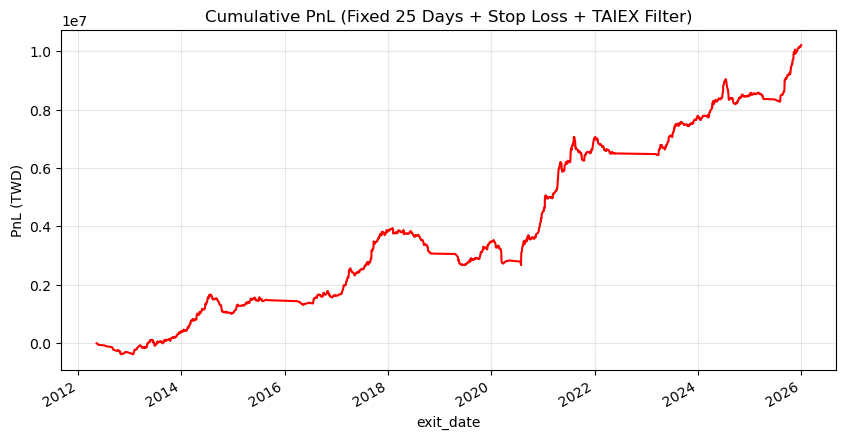

In [16]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 (修正版)
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 25 天
COOLING_OFF_DAYS = 5          # 進場冷卻期 20 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間 (同前)
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    # 使用 .at 來確保取回的是單一純量值，而非 Series
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 或者確保 benchmark 本身是 Series
        
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 25 Days + Stop Loss + TAIEX Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

開始回測 (固定持有 + 大盤濾網 + 每月10-15日進場)
期間: 2008-02-13 ~ 2025-12-31
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 2116
總損益: 6,187,309
平均報酬率: 2.93%
勝率: 48.30%
平均持有天數: 33.1 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
2106,6274,2025-10-13,2025-12-09,324.00,425.00,Time Exit (40 days),30682.426390,0.307420,308,40
2107,6139,2025-10-14,2025-12-10,437.00,508.00,Time Exit (40 days),15809.824950,0.158653,228,40
2108,2885,2025-10-15,2025-12-11,34.55,37.55,Time Exit (40 days),8323.380145,0.083261,2893,40
2109,2890,2025-10-15,2025-12-11,26.25,27.40,Time Exit (40 days),4037.069764,0.040381,3808,40
2110,1590,2025-10-15,2025-12-11,874.00,917.00,Time Exit (40 days),4559.291205,0.045753,114,40
2111,2481,2025-12-10,2025-12-15,91.20,80.50,Stop Loss (-10.0%),-12018.700106,-0.120224,1096,3
2112,2421,2025-11-10,2025-12-16,173.00,152.50,Stop Loss (-10.0%),-12119.240924,-0.121392,577,26
2113,8358,2025-12-11,2025-12-16,288.00,247.00,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
2114,8046,2025-12-11,2025-12-16,283.00,249.00,Stop Loss (-10.0%),-12292.451930,-0.123031,353,3
2115,2382,2025-12-11,2025-12-17,295.00,265.00,Stop Loss (-10.0%),-10435.682400,-0.104645,338,4


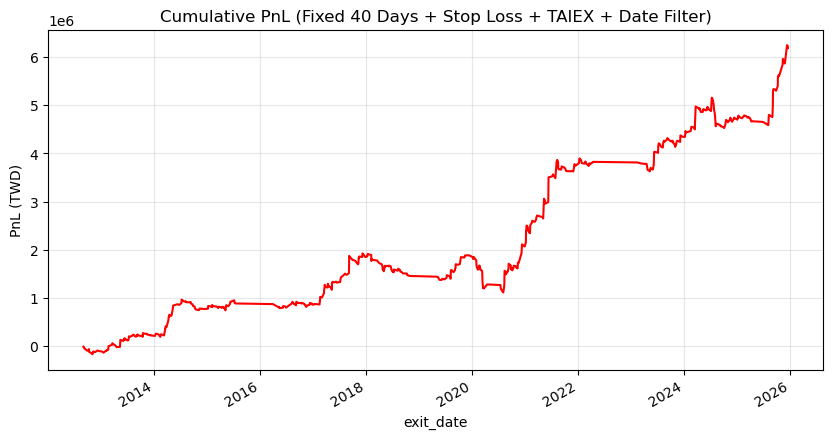


[2025-12-31] 目前持股: 40 檔
策略設定出場天數: 40 (Trading Days)


,Stock ID,Entry Date,Entry Price,Current Price,Shares,Cost,Mkt Value,Unrealized PnL,ROI (%),Trading Days,Calendar Days
0,2412 中華電 (智慧電網),2025-11-10,132.50,130.50,754,99919,98397,-1831,-1.83,36,51
5,2330 台積電 (半導體),2025-11-12,1470.00,1550.00,68,99974,105400,5094,5.10,34,49
8,8150 南茂 (半導體),2025-11-12,36.90,47.15,2709,99976,127729,27351,27.36,34,49
7,3711 日月光投控 (半導體),2025-11-12,227.00,250.50,440,99894,110220,9979,9.99,34,49
6,2382 廣達 (運動科技),2025-11-12,288.00,272.00,347,99950,94384,-5862,-5.87,34,49
1,3443 創意 (半導體),2025-11-12,1990.00,2125.00,50,99514,106250,6401,6.43,34,49
4,2449 京元電子 (半導體),2025-11-12,214.00,247.50,467,99952,115582,15267,15.27,34,49
3,2481 強茂 (半導體),2025-11-12,81.00,80.10,1234,99968,98843,-1435,-1.44,34,49
2,6770 力積電 (半導體),2025-11-12,33.45,39.55,2989,99996,118214,17847,17.85,34,49
9,2368 金像電 (印刷電路板),2025-11-13,560.00,687.00,178,99694,122286,22207,22.28,33,48


In [17]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 + 日期濾網
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 40 天
COOLING_OFF_DAYS = 5           # 進場冷卻期 5 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網 + 每月10-15日進場)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    # [新增] 限制每月 12 日前才進場 (包含 12 日)
    if today.day > 15 or today.day < 10:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 40 Days + Stop Loss + TAIEX + Date Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

# ======================================
# [新增功能] 顯示目前持股清單與未實現損益
# ======================================
current_date = backtest_dates[-1]
current_idx = len(backtest_dates) - 1  # 取得目前最後一天的 index
print(f"\n[{current_date.date()}] 目前持股: {len(positions)} 檔")
print(f"策略設定出場天數: {FIXED_HOLDING_DAYS} (Trading Days)")
if positions:
    holdings_list = []
    for pos in positions:
        stock_id = pos['stock_id']
        # 取得最後一天的價格
        curr_price = close_.at[current_date, stock_id] if stock_id in close_.columns and current_date in close_.index else float('nan')
        
        # 計算未實現損益
        market_val = curr_price * pos['shares'] if pd.notna(curr_price) else 0
        est_net_val = market_val * (1 - FEE_RATE - TAX_RATE)
        unrealized_pnl = est_net_val - pos['cost']
        roi = (unrealized_pnl / pos['cost']) * 100 if pos['cost'] != 0 else 0
        
        # [修正] 計算交易日數 (Trading Days)
        trading_days_held = current_idx - pos['entry_idx']
        
        # [選擇性] 計算日曆日數 (Calendar Days)
        calendar_days_held = (current_date - pos['entry_date']).days
        
        holdings_list.append({
            'Stock ID': get_display_info(stock_id),
            'Entry Date': pos['entry_date'].date(),
            'Entry Price': pos['entry_price'],
            'Current Price': curr_price,
            'Shares': pos['shares'],
            'Cost': int(pos['cost']),
            'Mkt Value': int(market_val),
            'Unrealized PnL': int(unrealized_pnl),
            'ROI (%)': round(roi, 2),
            'Trading Days': trading_days_held,   # 策略用的 K 棒數 (還沒到 40 就不會賣)
            'Calendar Days': calendar_days_held  # 自然天數 (含假日)
        })
        
    df_holdings = pd.DataFrame(holdings_list)
    # 按照持有天數排序觀察
    display(df_holdings.sort_values("Trading Days", ascending=False))
else:
    print("目前無持股")

------------------------------
策略效能總結表 (基準本金: 4,500,000)
------------------------------
1. 總損益 (PnL):      6,187,309 元
2. 總報酬率:          137.50 %
3. 年化報酬率 (CAGR): 4.96 %
4. 最大回撤 (MDD):    -12.60 %
5. 獲利因子 (PF):     1.64
6. 夏普比率 (Sharpe): 1.04
------------------------------
MDD 發生日期: 2020-08-03


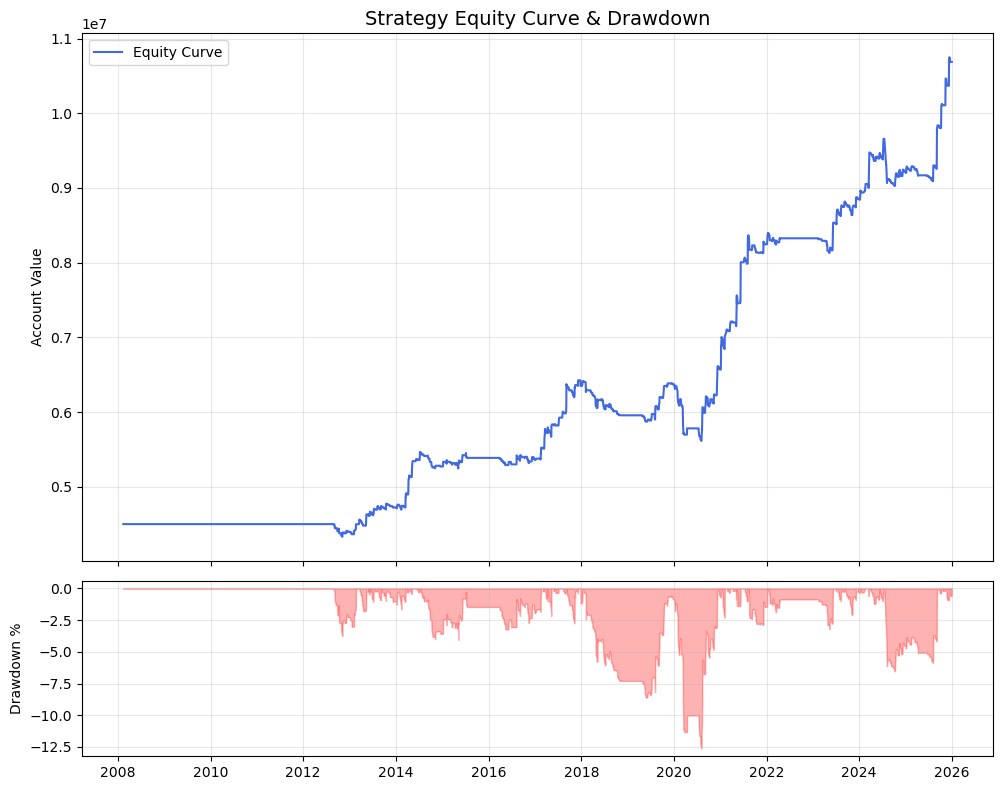

In [18]:
# ======================================
# [新增功能] 策略核心績效指標計算 (MDD, Sharpe, Profit Factor, CAGR)
# ======================================
import numpy as np

# 1. 準備金設定 (以您之前算出的最高曝光額作為本金參考值)
INITIAL_CAPITAL = 4500000  # 假設準備金為 450 萬

# 2. 建立每日權益曲線 (Realized PnL)
# 先統計每日實現損益
daily_realized_pnl = df_trades.groupby("exit_date")["pnl"].sum().reindex(backtest_dates, fill_value=0)
# 累計損益 + 本金
equity_curve = daily_realized_pnl.cumsum() + INITIAL_CAPITAL

# 3. 計算最大回撤 (MDD)
# 找出歷史最高點
running_max = equity_curve.cummax()
# 計算回撤金額與百分比
drawdown_amt = equity_curve - running_max
drawdown_pct = drawdown_amt / running_max
mdd_pct = drawdown_pct.min()
mdd_date = drawdown_pct.idxmin()

# 4. 計算年化報酬率 (CAGR)
total_days = (backtest_dates[-1] - backtest_dates[0]).days
years = total_days / 365.25
total_return = (equity_curve.iloc[-1] / INITIAL_CAPITAL) - 1
cagr = (1 + total_return)**(1/years) - 1

# 5. 計算夏普比率 (Sharpe Ratio)
# 使用每日收益率計算（假設無風險利率為 1%）
daily_returns = equity_curve.pct_change().dropna()
# 年化報酬率 / 年化標普 (通常乘上 sqrt(252) 代表交易日)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# 6. 獲利因子 (Profit Factor)
gross_profit = df_trades[df_trades['pnl'] > 0]['pnl'].sum()
gross_loss = abs(df_trades[df_trades['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

# ======================================
# 顯示報表
# ======================================
print("-" * 30)
print(f"策略效能總結表 (基準本金: {INITIAL_CAPITAL:,.0f})")
print("-" * 30)
print(f"1. 總損益 (PnL):      {df_trades['pnl'].sum():,.0f} 元")
print(f"2. 總報酬率:          {total_return*100:.2f} %")
print(f"3. 年化報酬率 (CAGR): {cagr*100:.2f} %")
print(f"4. 最大回撤 (MDD):    {mdd_pct*100:.2f} %")
print(f"5. 獲利因子 (PF):     {profit_factor:.2f}")
print(f"6. 夏普比率 (Sharpe): {sharpe_ratio:.2f}")
print("-" * 30)
print(f"MDD 發生日期: {mdd_date.date()}")

# 繪製資產曲線與回撤圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(equity_curve, color='royalblue', label='Equity Curve')
ax1.set_title("Strategy Equity Curve & Drawdown", fontsize=14)
ax1.set_ylabel("Account Value")
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.fill_between(drawdown_pct.index, drawdown_pct * 100, 0, color='red', alpha=0.3)
ax2.set_ylabel("Drawdown %")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Daily usage: 244.8 / 5000 MB - price:最高價
Daily usage: 273.0 / 5000 MB - price:最低價
開始回測 (ATR 移動停利 + 40天低獲利強制出場)
出場邏輯: 1.硬停損 10%  2.ATR 移動停利(3倍)  3.40天獲利低於5%出場

總交易次數: 1800
勝率: 40.78%
平均報酬率: 2.54%


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
1790,2481,2025-11-12,2025-12-15,81.0,80.5,ATR Trailing Stop (3.0x),-943.409968,-0.009437,1234,23
1791,8358,2025-11-13,2025-12-16,235.0,247.0,ATR Trailing Stop (3.0x),4755.883875,0.047612,425,23
1792,3264,2025-12-10,2025-12-16,93.2,89.6,ATR Trailing Stop (3.0x),-4175.278128,-0.041784,1072,4
1793,3706,2025-12-10,2025-12-16,88.4,80.2,ATR Trailing Stop (3.0x),-9573.491441,-0.095740,1131,4
1794,8046,2025-12-11,2025-12-16,283.0,249.0,Hard Stop Loss (-10.0%),-12292.451930,-0.123031,353,3
1795,2382,2025-12-11,2025-12-16,295.0,273.0,ATR Trailing Stop (3.0x),-7740.179720,-0.077616,338,3
1796,3443,2025-11-12,2025-12-17,1990.0,2010.0,ATR Trailing Stop (3.0x),670.000000,0.006733,50,25
1797,2330,2025-12-10,2025-12-17,1490.0,1430.0,ATR Trailing Stop (3.0x),-4335.308700,-0.043421,67,5
1798,3711,2025-11-12,2025-12-18,227.0,222.0,ATR Trailing Stop (3.0x),-2521.192300,-0.025239,440,26
1799,8039,2025-12-11,2025-12-30,94.2,86.6,ATR Trailing Stop (3.0x),-8366.583404,-0.083699,1061,12


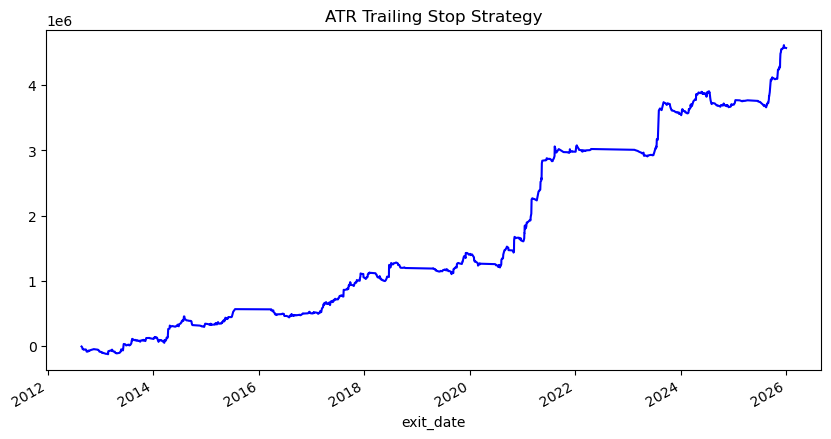

In [19]:
# ======================================
# 9. 優化策略：ATR 移動停利 + 40天效率出場 (修正版)
# ======================================

# 1. 取得與對齊資料
# 確保所有價格資料都使用 common_cols 並對齊 index
high_ = data.get("price:最高價")[common_cols]
low_ = data.get("price:最低價")[common_cols]
close_ = data.get("price:收盤價")[common_cols]
open_ = data.get("price:開盤價")[common_cols]

# 2. 技術指標計算 (修正 ATR 計算以支援 DataFrame)
def calculate_atr(high, low, close, window=14):
    # 計算 True Range (TR)
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    
    # 逐一比較取得最大值，確保結果依然是 DataFrame
    tr = tr1.combine(tr2, np.maximum).combine(tr3, np.maximum)
    return tr.rolling(window).mean()

atr_ = calculate_atr(high_, low_, close_, window=14)
ma60 = close_.rolling(60).mean()   # 進場濾網

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1
TAX_RATE = 0.003

# --- ATR 參數 ---
ATR_MULTIPLIER = 3.0             # 停利線：最高價 - (3倍ATR)
STOP_LOSS_PCT = 0.10             # 硬停損 10%
TIME_EXIT_DAYS = 40              # 效率檢查天數
TIME_EXIT_PROFIT_LIMIT = 0.05    # 持有滿 40 天若獲利低於 5% 則出場
COOLING_OFF_DAYS = 5             # 冷卻期
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (ATR 移動停利 + 40天低獲利強制出場)")
print(f"出場邏輯: 1.硬停損 10%  2.ATR 移動停利(3倍)  3.40天獲利低於5%出場")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 檢查該日期資料是否存在
        if today not in close_.index or stock_id not in close_.columns:
            continue
        if pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        current_high = high_.at[today, stock_id]
        current_atr = atr_.at[today, stock_id]
        held_days = i - pos['entry_idx']
        
        # 更新持股期間最高價
        if current_high > pos['max_price']:
            pos['max_price'] = current_high
        
        # 計算移動停利線 (最高價 - N倍ATR)
        trailing_stop_price = pos['max_price'] - (current_atr * ATR_MULTIPLIER)
        
        exit_reason = None
        
        # 1. 硬停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Hard Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. ATR 移動停利 (跌破最高價回檔線)
        elif current_close < trailing_stop_price:
            exit_reason = f"ATR Trailing Stop ({ATR_MULTIPLIER}x)"
        
        # 3. 效率出場條件
        elif held_days >= TIME_EXIT_DAYS:
            current_return = (current_close / pos['entry_price']) - 1
            if current_return < TIME_EXIT_PROFIT_LIMIT:
                exit_reason = f"Eff. Exit (Day {TIME_EXIT_DAYS}, <{TIME_EXIT_PROFIT_LIMIT*100}% Profit)"
        
        if exit_reason:
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': held_days 
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # 修正大盤濾網讀取方式
        if isinstance(benchmark, pd.DataFrame):
            bm_val = benchmark.loc[yesterday].iloc[0]
            ma_val = benchmark_ma200.loc[yesterday].iloc[0]
        else:
            bm_val = benchmark.loc[yesterday]
            ma_val = benchmark_ma200.loc[yesterday]
            
        if pd.notna(bm_val) and pd.notna(ma_val) and bm_val <= ma_val:
            market_filter_pass = False
    
    if not market_filter_pass or not (10 <= today.day <= 15):
        continue

    candidates = signal_dict.get(yesterday, [])
    for stock_id in candidates:
        if today not in open_.index or stock_id not in open_.columns or pd.isna(open_.at[today, stock_id]):
            continue
        # 60MA 濾網
        if pd.isna(ma60.at[yesterday, stock_id]) or close_.at[yesterday, stock_id] <= ma60.at[yesterday, stock_id]:
            continue
        if any(p['stock_id'] == stock_id for p in positions):
            continue
        
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        if last_date is not None:
            try:
                if (close_.index.get_loc(yesterday) - close_.index.get_loc(last_date)) <= COOLING_OFF_DAYS:
                    continue
            except: pass
            
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        if shares > 0:
            last_selected_date[stock_id] = yesterday
            cost = entry_price * shares * (1 + FEE_RATE)
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i,
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost,
                'max_price': entry_price 
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)
if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    display(df_trades.tail(10))
    
    df_trades = df_trades.sort_values("exit_date")
    plt.figure(figsize=(10, 5))
    df_trades.groupby("exit_date")["pnl"].sum().cumsum().plot(color="blue", title="ATR Trailing Stop Strategy")
    plt.show()
else:
    print("無交易紀錄")

------------------------------
策略效能總結表 (基準本金: 3,500,000)
------------------------------
1. 總損益 (PnL):      4,571,765 元
2. 總報酬率:          130.62 %
3. 年化報酬率 (CAGR): 4.78 %
4. 最大回撤 (MDD):    -4.53 %
5. 獲利因子 (PF):     1.73
6. 夏普比率 (Sharpe): 1.27
------------------------------
MDD 發生日期: 2020-07-28


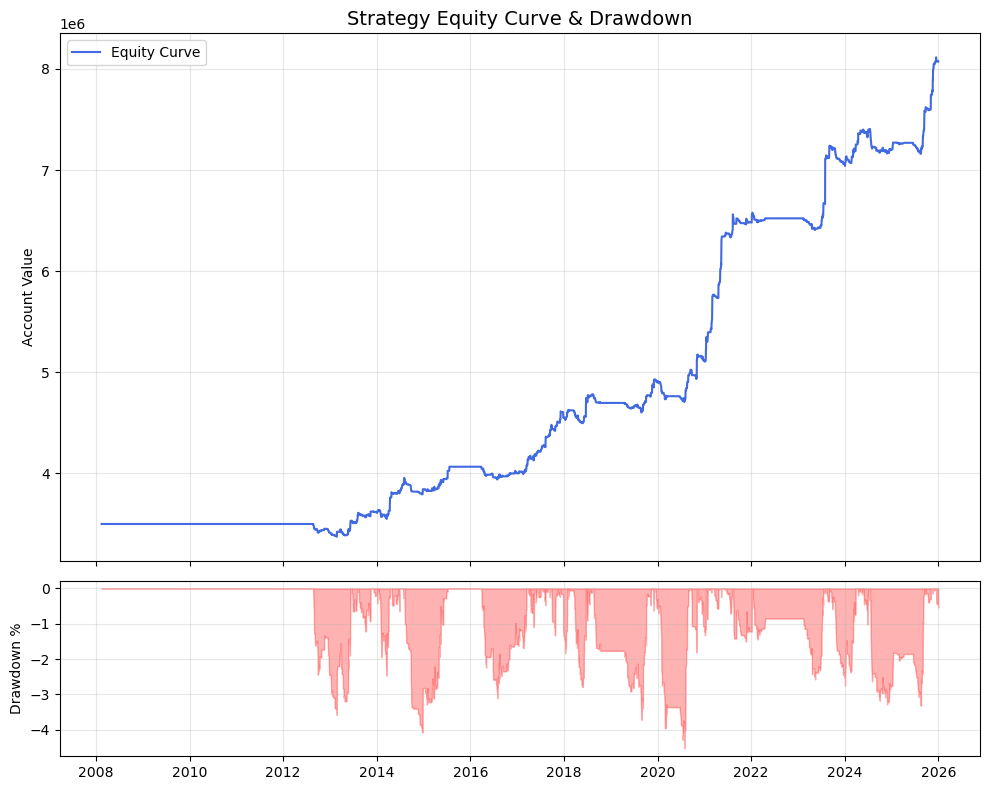

In [20]:
# ======================================
# [新增功能] 策略核心績效指標計算 (MDD, Sharpe, Profit Factor, CAGR)
# ======================================
import numpy as np

# 1. 準備金設定 (以您之前算出的最高曝光額作為本金參考值)
INITIAL_CAPITAL = 3500000  # 假設準備金為 450 萬

# 2. 建立每日權益曲線 (Realized PnL)
# 先統計每日實現損益
daily_realized_pnl = df_trades.groupby("exit_date")["pnl"].sum().reindex(backtest_dates, fill_value=0)
# 累計損益 + 本金
equity_curve = daily_realized_pnl.cumsum() + INITIAL_CAPITAL

# 3. 計算最大回撤 (MDD)
# 找出歷史最高點
running_max = equity_curve.cummax()
# 計算回撤金額與百分比
drawdown_amt = equity_curve - running_max
drawdown_pct = drawdown_amt / running_max
mdd_pct = drawdown_pct.min()
mdd_date = drawdown_pct.idxmin()

# 4. 計算年化報酬率 (CAGR)
total_days = (backtest_dates[-1] - backtest_dates[0]).days
years = total_days / 365.25
total_return = (equity_curve.iloc[-1] / INITIAL_CAPITAL) - 1
cagr = (1 + total_return)**(1/years) - 1

# 5. 計算夏普比率 (Sharpe Ratio)
# 使用每日收益率計算（假設無風險利率為 1%）
daily_returns = equity_curve.pct_change().dropna()
# 年化報酬率 / 年化標普 (通常乘上 sqrt(252) 代表交易日)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# 6. 獲利因子 (Profit Factor)
gross_profit = df_trades[df_trades['pnl'] > 0]['pnl'].sum()
gross_loss = abs(df_trades[df_trades['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

# ======================================
# 顯示報表
# ======================================
print("-" * 30)
print(f"策略效能總結表 (基準本金: {INITIAL_CAPITAL:,.0f})")
print("-" * 30)
print(f"1. 總損益 (PnL):      {df_trades['pnl'].sum():,.0f} 元")
print(f"2. 總報酬率:          {total_return*100:.2f} %")
print(f"3. 年化報酬率 (CAGR): {cagr*100:.2f} %")
print(f"4. 最大回撤 (MDD):    {mdd_pct*100:.2f} %")
print(f"5. 獲利因子 (PF):     {profit_factor:.2f}")
print(f"6. 夏普比率 (Sharpe): {sharpe_ratio:.2f}")
print("-" * 30)
print(f"MDD 發生日期: {mdd_date.date()}")

# 繪製資產曲線與回撤圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(equity_curve, color='royalblue', label='Equity Curve')
ax1.set_title("Strategy Equity Curve & Drawdown", fontsize=14)
ax1.set_ylabel("Account Value")
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.fill_between(drawdown_pct.index, drawdown_pct * 100, 0, color='red', alpha=0.3)
ax2.set_ylabel("Drawdown %")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

啟動基金組合回測：固定規模 15 檔

--- 基金組合回測報告 ---
最終淨值: 4,574,967
累積報酬率: 205.00%
最大回撤 (MDD): -14.58%
總交易筆數: 842


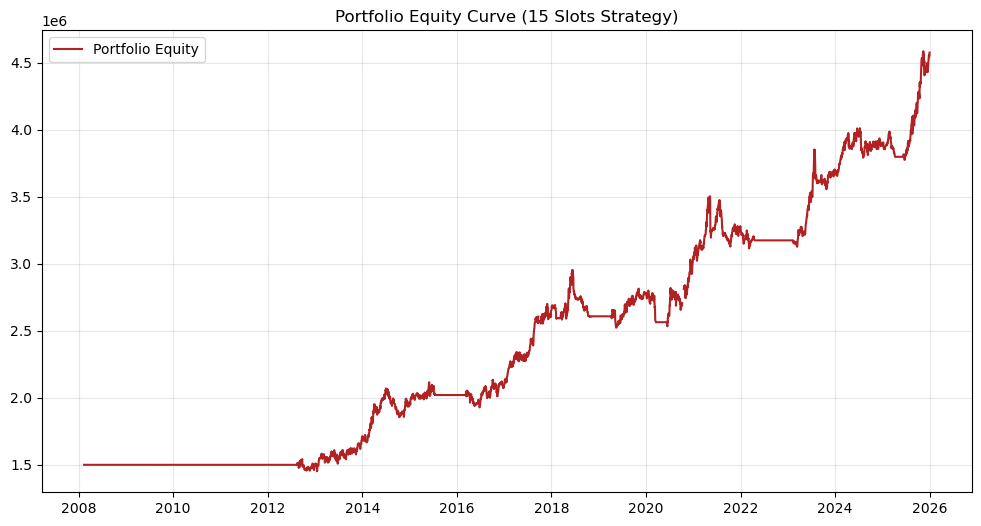

In [22]:
# ======================================
# 10. 基金組合管理：固定持有 15 檔策略
# ======================================

# 1. 參數設定
MAX_POSITIONS = 15               # [核心] 固定持有 15 檔
TOTAL_CAPITAL = 1_500_000        # 初始總資金
CAPITAL_PER_SLOT = TOTAL_CAPITAL / MAX_POSITIONS  # 每檔分配權重 (等權重)

# 沿用之前的出場參數
PROFIT_ACTIVATION_PCT = 0.20     
ATR_MULTIPLIER = 3.0             
STOP_LOSS_PCT = 0.10             
TIME_EXIT_DAYS = 40              
TIME_EXIT_PROFIT_LIMIT = 0.05    
COOLING_OFF_DAYS = 5 

# 2. 初始化狀態
portfolio = []                   # 當前持股名單
cash = TOTAL_CAPITAL             # 帳戶餘額
portfolio_values = []            # 紀錄每日淨值
trade_history = []
last_selected_date = {}

# 3. 開始回測循環
backtest_dates = close_.index[200:]
print(f"啟動基金組合回測：固定規模 {MAX_POSITIONS} 檔")

for i, today in enumerate(backtest_dates):
    yesterday = backtest_dates[i-1] if i > 0 else today
    
    # --- A. 更新帳戶價值 (每日計算) ---
    current_pos_value = 0
    for pos in portfolio:
        current_pos_value += close_.at[today, pos['stock_id']] * pos['shares']
    portfolio_values.append({'date': today, 'equity': cash + current_pos_value})

    # --- B. 檢查組合內股票是否該「剔除」 ---
    for pos in portfolio[:]:
        stock_id = pos['stock_id']
        if today not in close_.index or stock_id not in close_.columns or pd.isna(close_.at[today, stock_id]):
            continue
            
        cur_close = close_.at[today, stock_id]
        cur_high = high_.at[today, stock_id]
        cur_atr = atr_.at[today, stock_id]
        held_days = i - pos['entry_idx']
        
        # 更新最高價與停利開關
        if cur_high > pos['max_price']:
            pos['max_price'] = cur_high
        
        max_ret = (pos['max_price'] / pos['entry_price']) - 1
        if not pos['trailing_active'] and max_ret >= PROFIT_ACTIVATION_PCT:
            pos['trailing_active'] = True

        exit_reason = None
        # 判斷條件
        if cur_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = "Hard Stop Loss"
        elif pos['trailing_active'] and cur_close < (pos['max_price'] - cur_atr * ATR_MULTIPLIER):
            exit_reason = "ATR Trailing Stop"
        elif held_days >= TIME_EXIT_DAYS and (cur_close/pos['entry_price']-1) < TIME_EXIT_PROFIT_LIMIT:
            exit_reason = "Efficiency Exit"

        if exit_reason:
            # 賣出，錢回到餘額
            sell_amount = cur_close * pos['shares'] * (1 - FEE_RATE - TAX_RATE)
            cash += sell_amount
            
            pnl = sell_amount - pos['cost']
            trade_history.append({
                'stock_id': stock_id, 'entry_date': pos['entry_date'], 'exit_date': today,
                'pnl': pnl, 'return': pnl / pos['cost'], 'reason': exit_reason
            })
            portfolio.remove(pos)

    # --- C. 檢查是否需要「補人」進組合 (Entry Window) ---
    # 只要在進場窗口 10-15 號，且籃子沒滿，就補強勢股
    if 10 <= today.day <= 15:
        # 1. 大盤濾網
        market_ok = True
        if yesterday in benchmark.index:
            bm = benchmark.loc[yesterday]
            ma = benchmark_ma200.loc[yesterday]
            if (bm.iloc[0] if isinstance(bm, pd.Series) else bm) <= (ma.iloc[0] if isinstance(ma, pd.Series) else ma):
                market_ok = False
        
        if market_ok and len(portfolio) < MAX_POSITIONS:
            candidates = signal_dict.get(yesterday, [])
            for stock_id in candidates:
                if len(portfolio) >= MAX_POSITIONS: break # 補滿為止
                
                # 基本檢查：不在組合內、資料正常、過濾均線
                if any(p['stock_id'] == stock_id for p in portfolio): continue
                if today not in open_.index or stock_id not in open_.columns or pd.isna(open_.at[today, stock_id]): continue
                if close_.at[yesterday, stock_id] <= ma60.at[yesterday, stock_id]: continue
                
                # 執行買入
                entry_p = open_.at[today, stock_id]
                buy_budget = CAPITAL_PER_SLOT # 固定每一份的預算
                shares = int(buy_budget / (entry_p * (1 + FEE_RATE)))
                
                if shares > 0 and cash >= (entry_p * shares * (1 + FEE_RATE)):
                    cost = entry_p * shares * (1 + FEE_RATE)
                    cash -= cost
                    portfolio.append({
                        'stock_id': stock_id, 'entry_date': today, 'entry_idx': i,
                        'entry_price': entry_p, 'shares': shares, 'cost': cost,
                        'max_price': entry_p, 'trailing_active': False
                    })

# ======================================
# 11. 組合表現分析
# ======================================
df_equity = pd.DataFrame(portfolio_values).set_index('date')
df_equity['drawdown'] = (df_equity['equity'] / df_equity['equity'].cummax()) - 1

print(f"\n--- 基金組合回測報告 ---")
print(f"最終淨值: {df_equity['equity'].iloc[-1]:,.0f}")
print(f"累積報酬率: {(df_equity['equity'].iloc[-1] / TOTAL_CAPITAL - 1) * 100:.2f}%")
print(f"最大回撤 (MDD): {df_equity['drawdown'].min() * 100:.2f}%")
print(f"總交易筆數: {len(trade_history)}")

# 繪製淨值曲線
plt.figure(figsize=(12, 6))
plt.plot(df_equity['equity'], label='Portfolio Equity', color='firebrick')
plt.title("Portfolio Equity Curve (15 Slots Strategy)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- 交易統計分析 ---
總交易筆數: 842 筆
勝率: 52.26%
【平均每筆報酬率】: 3.45%
總累積損益: $2,896,501

--- 出場原因分類分析 ---


,成交筆數,平均報酬率,標準差,合計損益
reason,,,,
ATR Trailing Stop,263,22.36%,0.224965,"$5,874,302"
Efficiency Exit,342,-0.33%,0.036174,"$-112,369"
Hard Stop Loss,237,-12.10%,0.017115,"$-2,865,433"


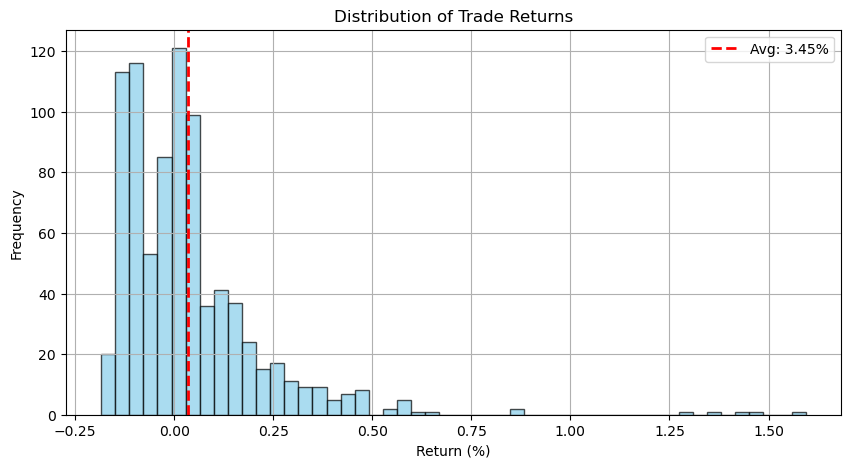

In [23]:
# ======================================
# 12. 進階績效分析：查看平均獲利
# ======================================
if len(trade_history) > 0:
    df_results = pd.DataFrame(trade_history)
    
    # 1. 基礎統計
    avg_return = df_results['return'].mean() * 100
    win_rate = (df_results['return'] > 0).mean() * 100
    total_pnl = df_results['pnl'].sum()
    
    print(f"--- 交易統計分析 ---")
    print(f"總交易筆數: {len(df_results)} 筆")
    print(f"勝率: {win_rate:.2f}%")
    print(f"【平均每筆報酬率】: {avg_return:.2f}%")
    print(f"總累積損益: ${total_pnl:,.0f}")
    
    # 2. 分類統計 (依據出場原因)
    print("\n--- 出場原因分類分析 ---")
    reason_stats = df_results.groupby('reason').agg({
        'return': ['count', 'mean', 'std'],
        'pnl': 'sum'
    })
    # 格式化顯示
    reason_stats.columns = ['成交筆數', '平均報酬率', '標準差', '合計損益']
    reason_stats['平均報酬率'] = (reason_stats['平均報酬率'] * 100).map('{:.2f}%'.format)
    reason_stats['合計損益'] = reason_stats['合計損益'].map('${:,.0f}'.format)
    display(reason_stats)

    # 3. 獲利分佈圖
    plt.figure(figsize=(10, 5))
    df_results['return'].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(df_results['return'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Avg: {avg_return:.2f}%')
    plt.title("Distribution of Trade Returns")
    plt.xlabel("Return (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

else:
    print("目前尚無完成交易所產生的獲利資料。")